# 0D Reactor: Postprocessing the FNN for the Trunk

In [1]:
### Importing Libraries

import sys
print(sys.version)
import os
import time


### Defining WORKSPACE_PATH

# WORKSPACE_PATH = os.environ['WORKSPACE_PATH']
WORKSPACE_PATH = os.path.join(os.getcwd(), '../../../../../../../')
ROMNet_fld     = os.path.join(WORKSPACE_PATH, 'ROMNet/romnet/')

### Importing External Libraries

import numpy                             as np
import pandas                            as pd


### Importing Matplotlib and Its Style

import matplotlib.pyplot                 as plt

#plt.style.use(os.path.join(WORKSPACE_PATH, 'ROMNet/romnet/extra/postprocessing/presentation.mplstyle'))
plt.style.use(os.path.join(WORKSPACE_PATH, 'ROMNet/romnet/extra/postprocessing/zoomed.mplstyle'))
#plt.style.use(os.path.join(WORKSPACE_PATH, 'ROMNet/romnet/extra/postprocessing/paper_1column.mplstyle'))
#plt.style.use(os.path.join(WORKSPACE_PATH, 'ROMNet/romnet/extra/postprocessing/paper_2columns.mplstyle'))


# from scipy.integrate import solve_ivp
# import pyDOE
# from PCAfold         import PCA          as PCAA


import romnet                            as rmnt

3.9.12 (main, Mar 26 2022, 15:51:13) 
[Clang 12.0.0 (clang-1200.0.32.29)]


Missing colon in file PosixPath('/Users/sventur/.matplotlib/stylelib/paper_2columns.mplstyle'), line 1 ('f#### MATPLOTLIBRC FORMAT')


## Defining Input Variables

In [2]:
#PCAType         = 'All'

PCAType         = 'OneByOne'
iVar            = 2
Vars            = ['x','v']
Var             = Vars[iVar-1]


if (PCAType == 'OneByOne'):
    #path_to_run_fld = os.path.join(WORKSPACE_PATH, 'ROMNet/MSD_100Cases_PCA_'+str(i_red)+'_Trunk/FNN/TestCase3/')
    path_to_run_fld = os.path.join(WORKSPACE_PATH, 'ROMNet/MSD_100Cases_2PCA/Var'+str(iVar)+'_Trunk/FNN/Run_1/')
elif (PCAType == 'All'):
    path_to_run_fld = os.path.join(WORKSPACE_PATH, 'ROMNet/MSD_100Cases_2PCA/All_Trunk/FNN/Run_1/')
    #path_to_run_fld = os.path.join(WORKSPACE_PATH, 'ROMNet/MSD_100Cases_PCA_All_Trunk/FNN/Run_1/')

FigDir          = None #os.path.join(WORKSPACE_PATH, '../Desktop/Paper_Figures_DeepONet_TEMP/')


TrainingCases   = [0]#[0,2,4,6,8]
TestCases       = [0,2,4]#[0,2]

LineVec         = ['-',':','--','.-']*10
ColorVec        = ['#190707', '#dd3232', '#0065a9', '#348a00','#985396','#f68b69']

## Loading ROMNet's Input Data File

In [3]:
np.savetxt('./iVar.csv', np.array([[iVar]], dtype=int), fmt='%i')

print("\n[ROMNet]: Reading Input File from: ", path_to_run_fld)
sys.path.insert(0, path_to_run_fld)

print("\n[ROMNet]: Keep Loading Modules and Functions...")
from ROMNet_Input import inputdata

print("\n[ROMNet]: Initializing Input ...")
InputData                 = inputdata(WORKSPACE_PATH)


InputData.InputFilePath   = path_to_run_fld+'/ROMNet_Input.py'
InputData.train_int_flg   = 0
InputData.path_to_run_fld = path_to_run_fld


[ROMNet]: Reading Input File from:  /Users/sventur/WORKSPACE/ROMNet/romnet/scripts/postprocessing/ScenarioAggregated_ROMS/MassSpringDamper/FNN/../../../../../../../ROMNet/MSD_100Cases_2PCA/Var2_Trunk/FNN/Run_1/

[ROMNet]: Keep Loading Modules and Functions...

[ROMNet]: Initializing Input ...


## Loading Tensorflow's Model for the Network 

In [4]:
surrogate_type = InputData.surrogate_type
if (surrogate_type == 'FNN-SourceTerms'):
    surrogate_type = 'FNN'

Net   = getattr(rmnt.architecture, surrogate_type)

model = rmnt.model.Model_TF(InputData)

if (InputData.phys_system is not None):
    System = getattr(rmnt.pinn.system, InputData.phys_system)
    system = System(InputData)
    
model.build(InputData, None, Net, system)#, loadfile_no='000027')

NN    = model.net


[ROMNet - model_tf.py    ]:   Initializing the ML Model

[ROMNet - model_tf.py    ]:   Building the ML Model

[ROMNet - fnn.py                    ]:   Constructing Feed-Forward Network: 
[ROMNet - system_of_components.py   ]:     Constructing System of Components: FNN
[ROMNet - component.py              ]:       Constructing Component: FNN
[ROMNet - sub_component.py          ]:         Constructed Sub-Component: Main with Layers:       ListWrapper([<keras.layers.core.dense.Dense object at 0x1726bb970>, <keras.layers.core.dense.Dense object at 0x1726bbb50>, <keras.layers.core.dense.Dense object at 0x1726c6be0>, <keras.layers.core.dense.Dense object at 0x1726c6f40>])

[ROMNet - model_tf.py    ]:   Loading ML Model Parameters from File:  /Users/sventur/WORKSPACE/ROMNet/romnet/scripts/postprocessing/ScenarioAggregated_ROMS/MassSpringDamper/FNN/../../../../../../../ROMNet/MSD_100Cases_2PCA/Var2_Trunk/FNN/Run_1//Training/Params//143249.h5
[ROMNet - hdf5_format.py            ]:     Loaded We

## Evaluating Trunk on Test Data

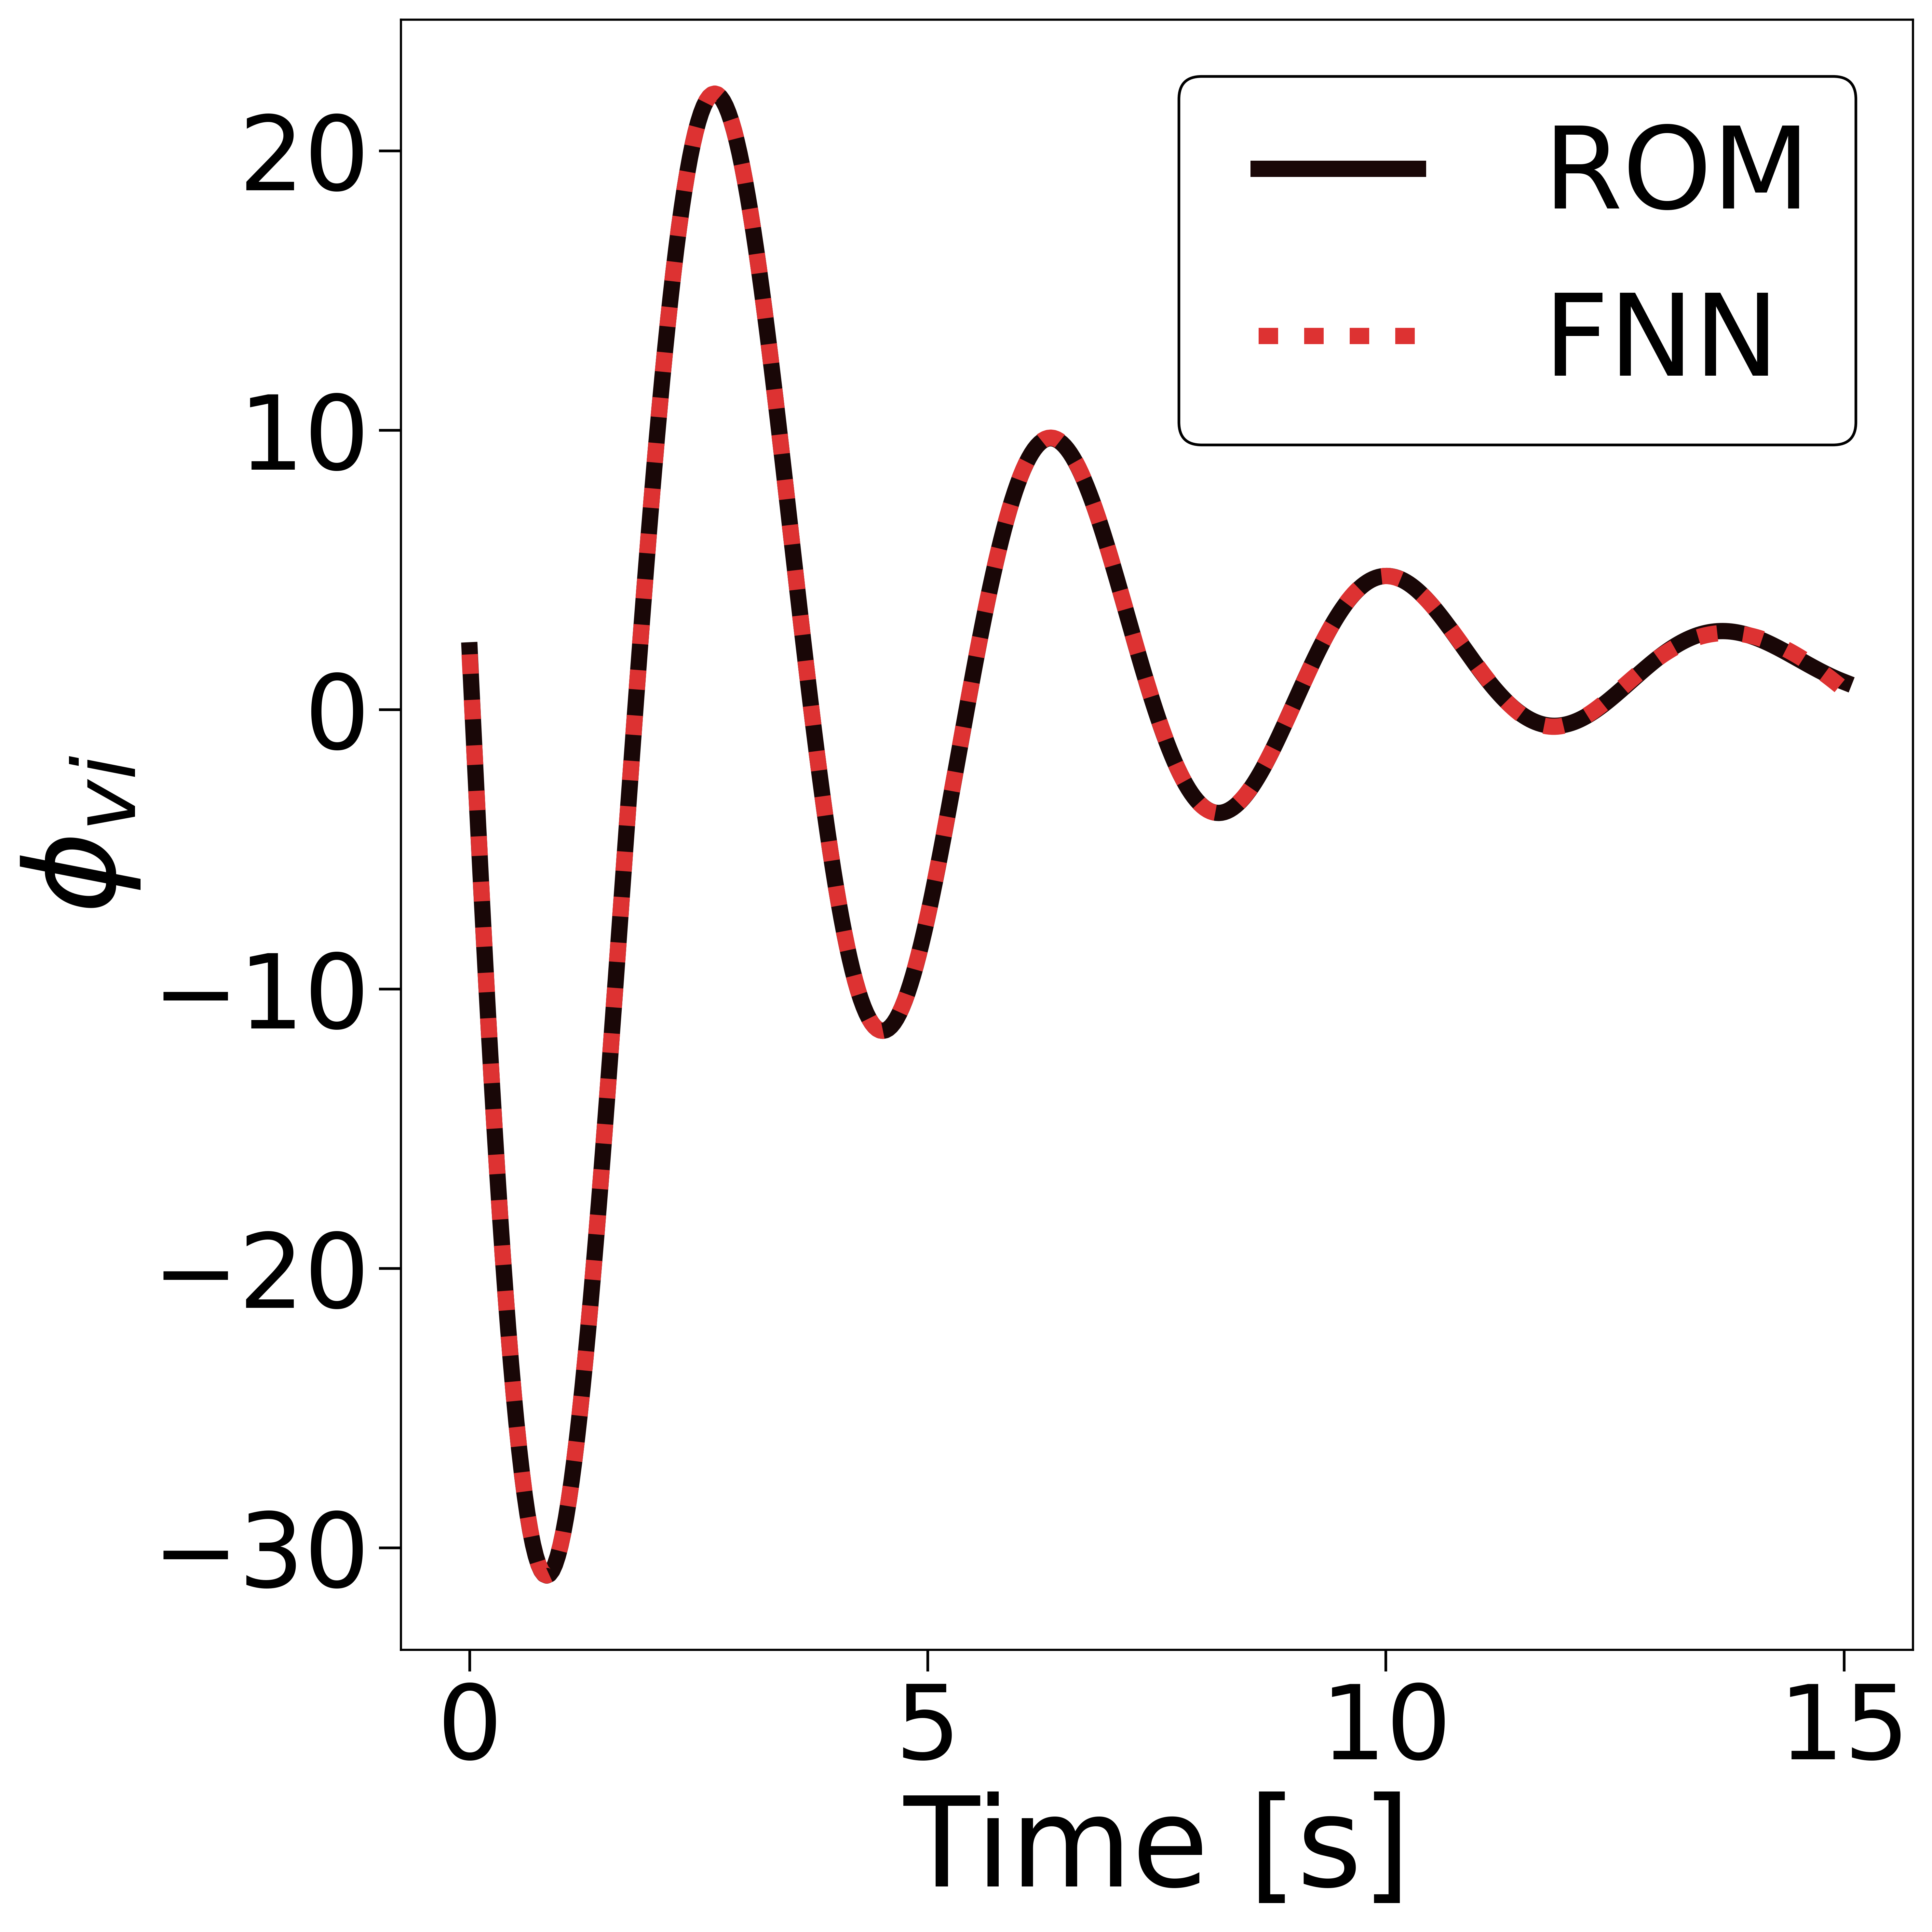

In [5]:
Vars      = ['t_'+str(i_mode+1) for i_mode in range(InputData.NRODs)]

FileName  = InputData.path_to_data_fld + '/test/pts/Input.csv'# + InputData.InputFile
Data      = pd.read_csv(FileName, header=0)
tVec      = Data['t'].to_numpy()[...,np.newaxis]
VarNames  = list(Data.columns).remove('t')

FileName  = InputData.path_to_data_fld + '/test/pts/Output.csv'# + InputData.InputFile
Data      = pd.read_csv(FileName, header=0)
Output    = Data[Vars].to_numpy()

tVecPred  = np.linspace(0.,15.,1000)[...,np.newaxis]

        
yMat      = model.predict(tVec) 
yMatPred  = model.predict(tVecPred) 



fig = plt.figure()
#for i in range(InputData.NRODs):
for i in [0]:
    if (i==0):
        Label1 = 'ROM'
        Label2 = 'FNN'
    else:
        Label1 = None
        Label2 = None
    plt.plot(tVec, Output[:,i], '-',   color=ColorVec[0], label=Label1)
    plt.plot(tVec, yMat[:,i],     ':', color=ColorVec[1], label=Label2)


plt.xlabel('Time [s]')
plt.ylabel(r'$\phi_{'+Var+'i}$')

plt.legend()

fig.tight_layout()  # otherwise the right y-label is slightly clipped

if (FigDir):
    if (PCAType == 'All'):
        plt.savefig(FigDir+'/MSD_100Cases_All_Trunk.eps', format='eps', bbox_inches='tight')
    else:
        plt.savefig(FigDir+'/MSD_100Cases_OneByOne_Trunk_'+Var+'.eps', format='eps', bbox_inches='tight')

In [6]:
print('[PCA]  Max % Error = ', np.max(abs((yMat - Output)/yMat)*100))
print('[PCA]  Max      SE = ', np.max((yMat - Output)**2))
print('[PCA] Mean % Error = ', np.mean(abs((yMat - Output)/yMat)*100))
print('[PCA]          MSE = ', np.mean((yMat - Output)**2))

[PCA]  Max % Error =  1215.6939541773447
[PCA]  Max      SE =  0.07228304989756149
[PCA] Mean % Error =  3.8871905743014987
[PCA]          MSE =  0.0007180795314444691


## Plotting Loss Histories

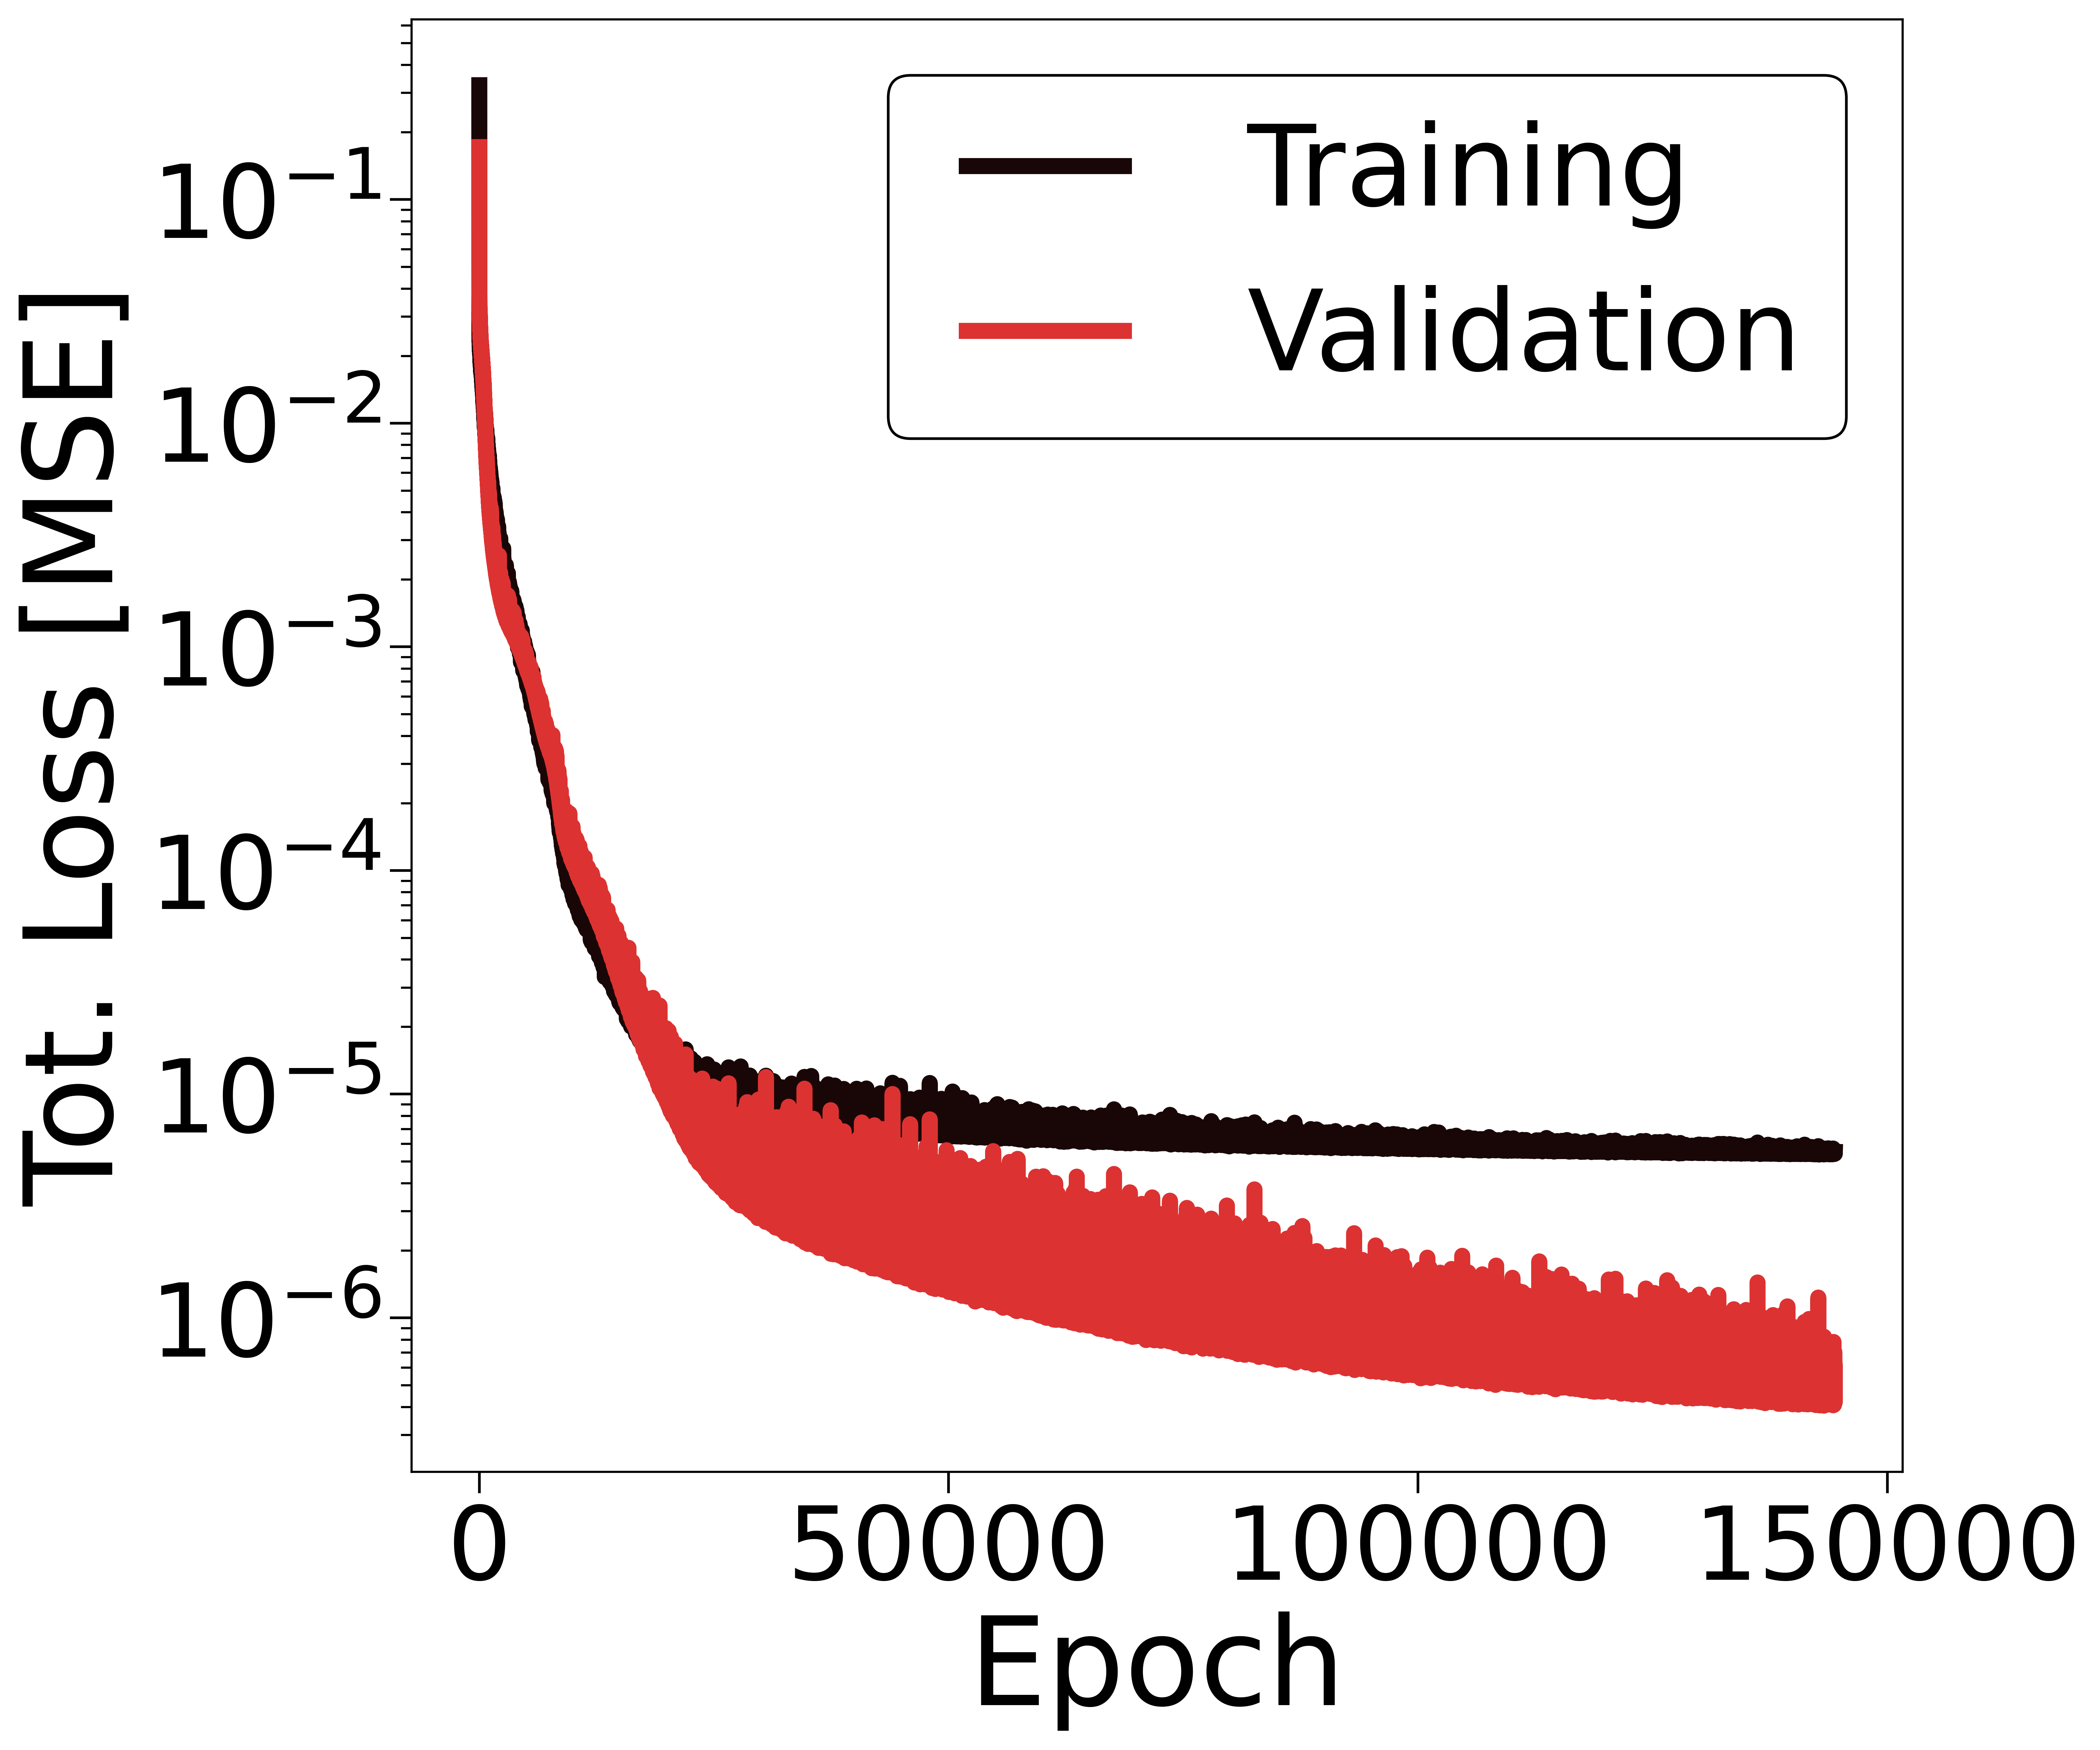

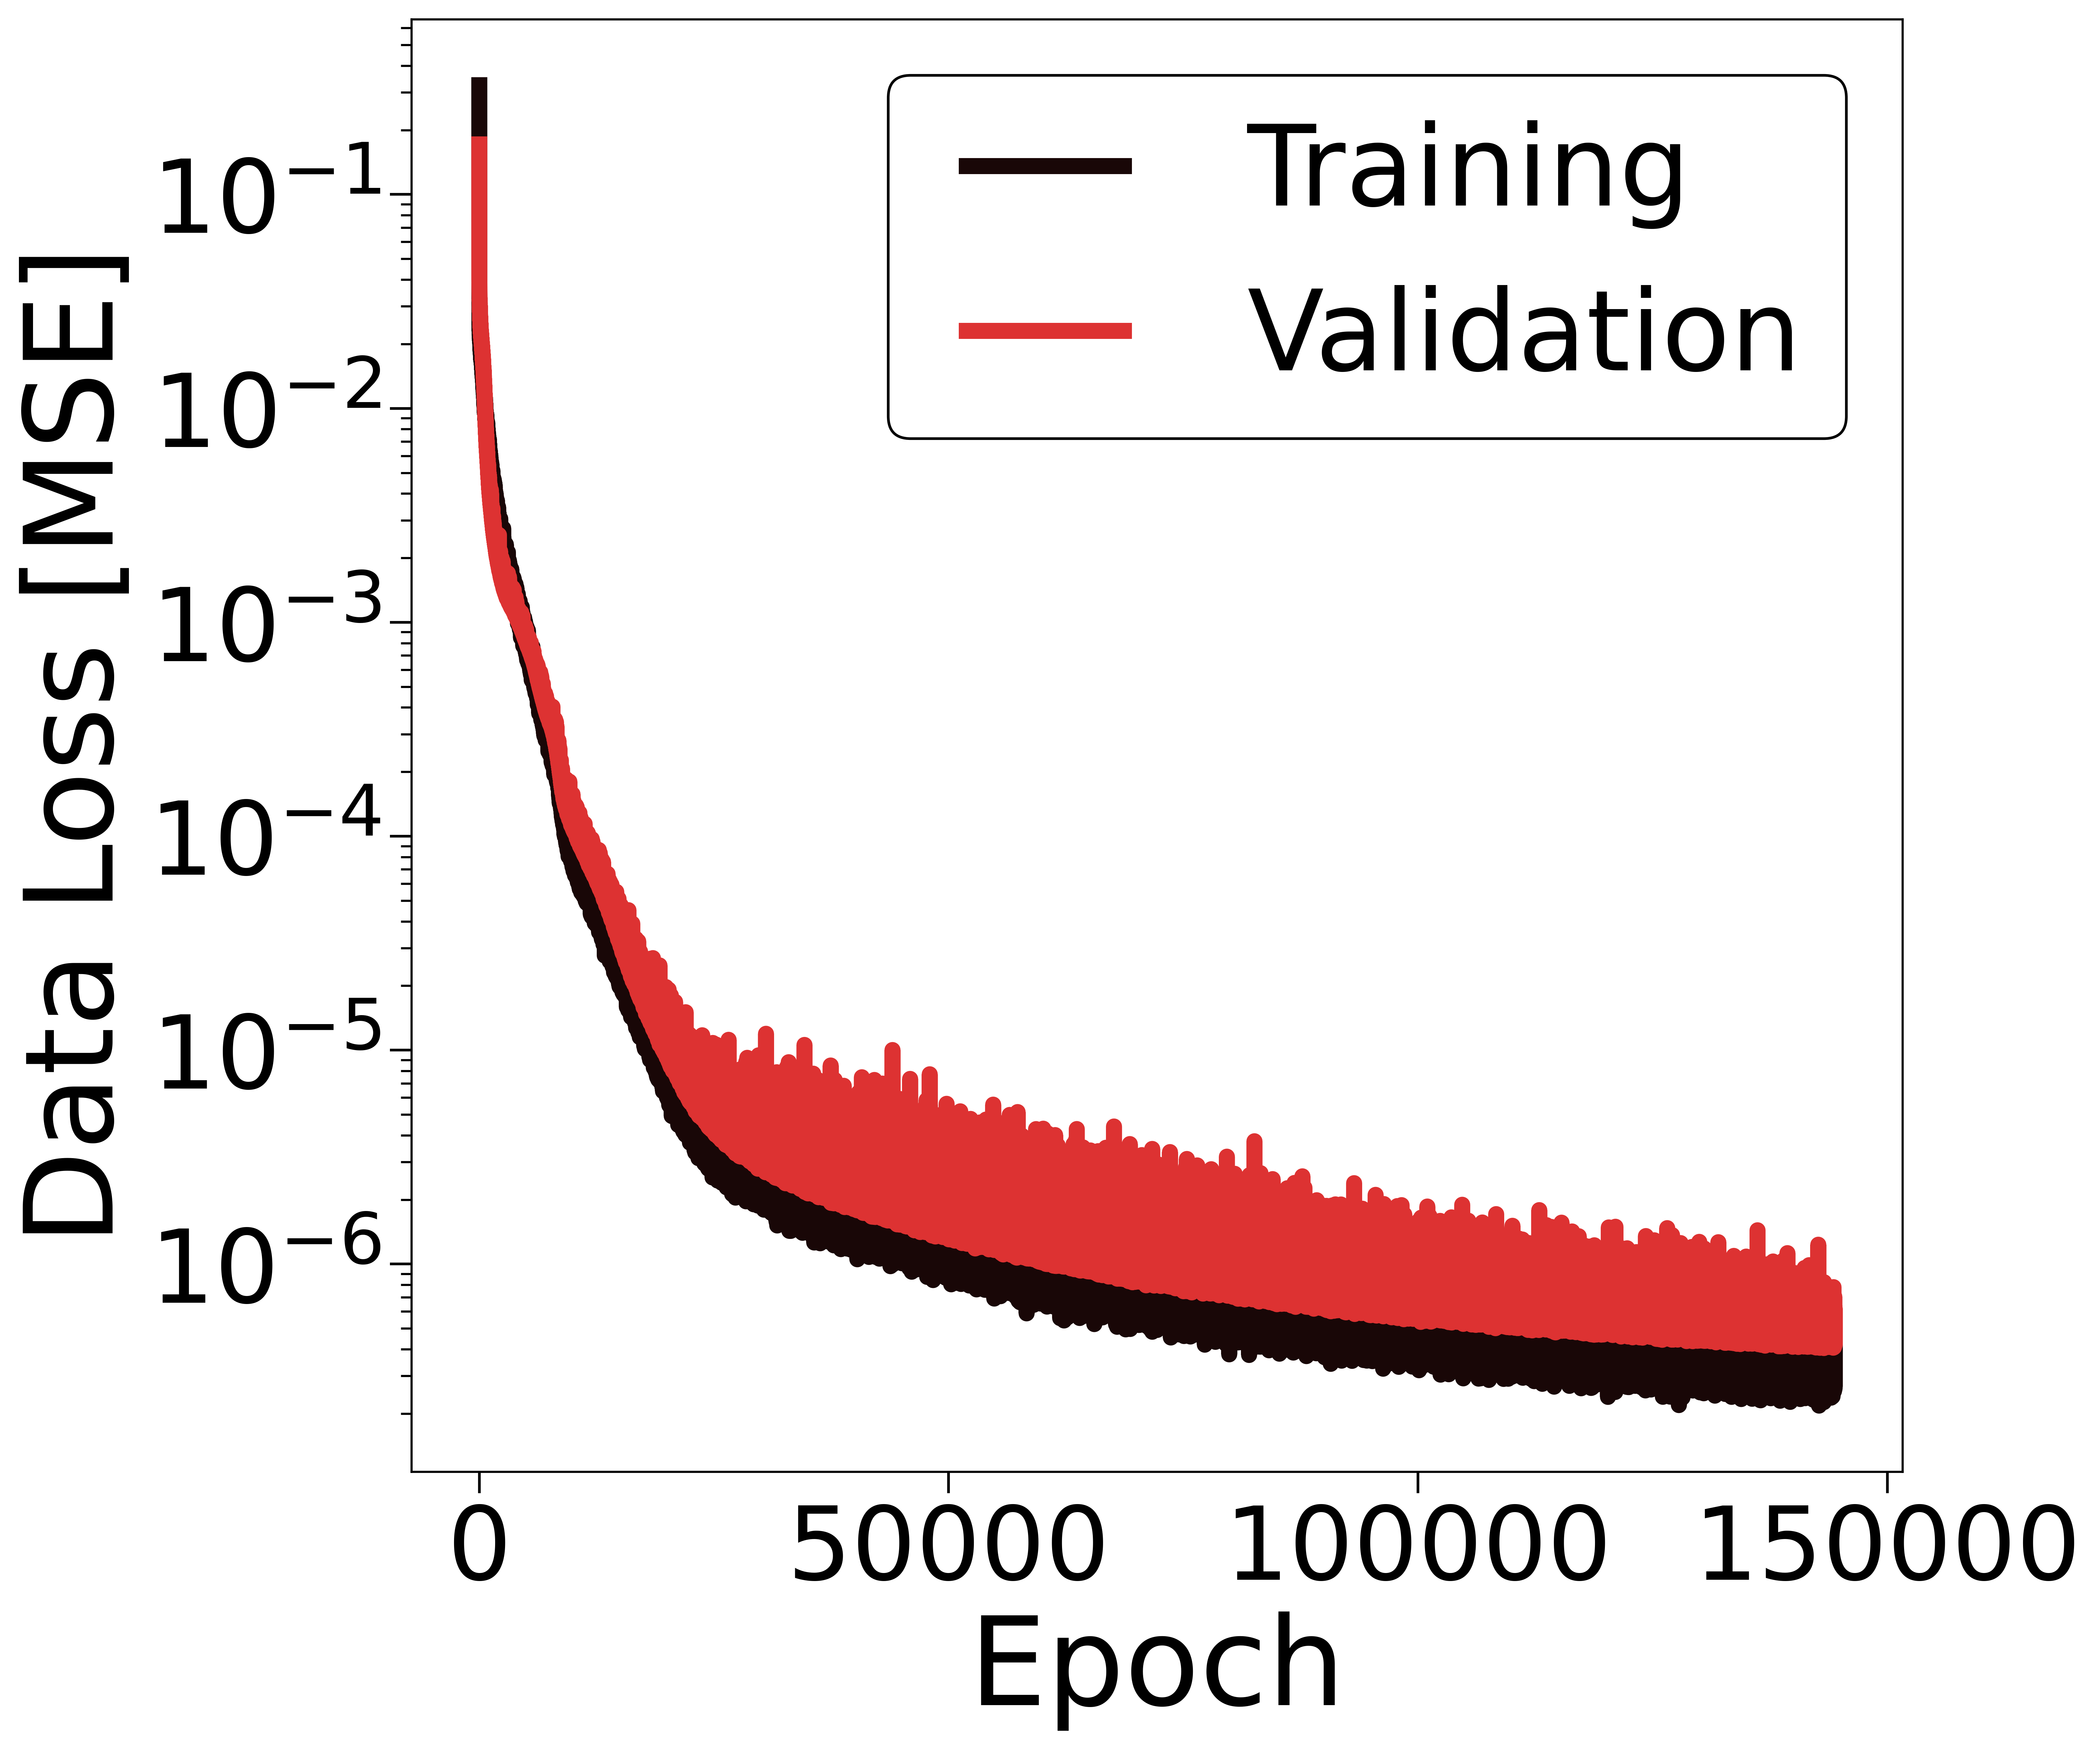

In [7]:
Data = pd.read_csv(path_to_run_fld+'/Training/History.csv')

fig  = plt.figure()
plt.plot(Data['tot_loss'],     label='Training')
plt.plot(Data['val_tot_loss'], label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Tot. Loss [MSE]')
plt.legend()
plt.yscale('log')

fig  = plt.figure()
plt.plot(Data['pts_loss'],     label='Training')
plt.plot(Data['val_pts_loss'], label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Data Loss [MSE]')
plt.legend()
plt.yscale('log')
#plt.ylim([1.e-2, 1.e0])

# fig  = plt.figure(figsize=(12,8))
# plt.plot(Data['scs_loss'],     label='Training')
# plt.plot(Data['val_scs_loss'], label='Validation')
# plt.xlabel('Epoch')
# plt.ylabel('S.C.s Loss [MSE]')
# plt.legend()
# plt.yscale('log')

# fig  = plt.figure(figsize=(12,8))
# plt.plot(Data['ics_loss'],     label='Training')
# plt.plot(Data['val_ics_loss'], label='Validation')
# plt.xlabel('Epoch')
# plt.ylabel('I.C.s Loss [MSE]')
# plt.legend()
# plt.yscale('log')

In [8]:
#path_to_data_fld = InputData.path_to_data_fld
path_to_data_fld = '/Users/sventur/WORKSPACE/ROMNet/Data/MSD_100Cases/2PCA/OneByOne/Var'+str(iVar)+'/Trunk/'

In [9]:
tVars           = ['t_'+str(i+1) for i in range(2)]
bVars           = ['b_'+str(i+1) for i in range(2)]

InputDF         = pd.read_csv(path_to_data_fld+'/test/pts/Input.csv')
OutputDF        = pd.read_csv(path_to_data_fld+'/test/pts/Output.csv')

InputDF_branch  = pd.read_csv(path_to_data_fld+'/../Branch/test/pts/Input.csv')
OutputDF_branch = pd.read_csv(path_to_data_fld+'/../Branch/test/pts/Output.csv')

In [10]:
A               = OutputDF_branch[bVars].to_numpy()
Psi             = OutputDF[tVars].to_numpy()
C               = OutputDF_branch['c'].to_numpy()
D               = OutputDF_branch['d'].to_numpy()

n_scenarios     = A.shape[0]
n_t             = Psi.shape[0]

Y               = np.zeros((n_t,n_scenarios))
YPred_          = np.zeros((n_t,n_scenarios))
YPred           = np.zeros((1000,n_scenarios))
for i_scenario in range(n_scenarios):
    Y[:,i_scenario]      = np.sum(Psi  * A[i_scenario,:], axis=1) * D[i_scenario] + C[i_scenario]
    YPred_[:,i_scenario] = np.sum(yMat * A[i_scenario,:], axis=1) * D[i_scenario] + C[i_scenario]
    YPred[:,i_scenario]  = np.sum(yMatPred * A[i_scenario,:], axis=1) * D[i_scenario] + C[i_scenario]
    
MSE  = (YPred_[1::] - Y[1::])**2
RMSE = np.sqrt( MSE.sum() / (MSE.shape[0]) / (MSE.shape[1]) )
print('Root Mean Squared Error = ', RMSE)

Root Mean Squared Error =  0.0037334455587375564


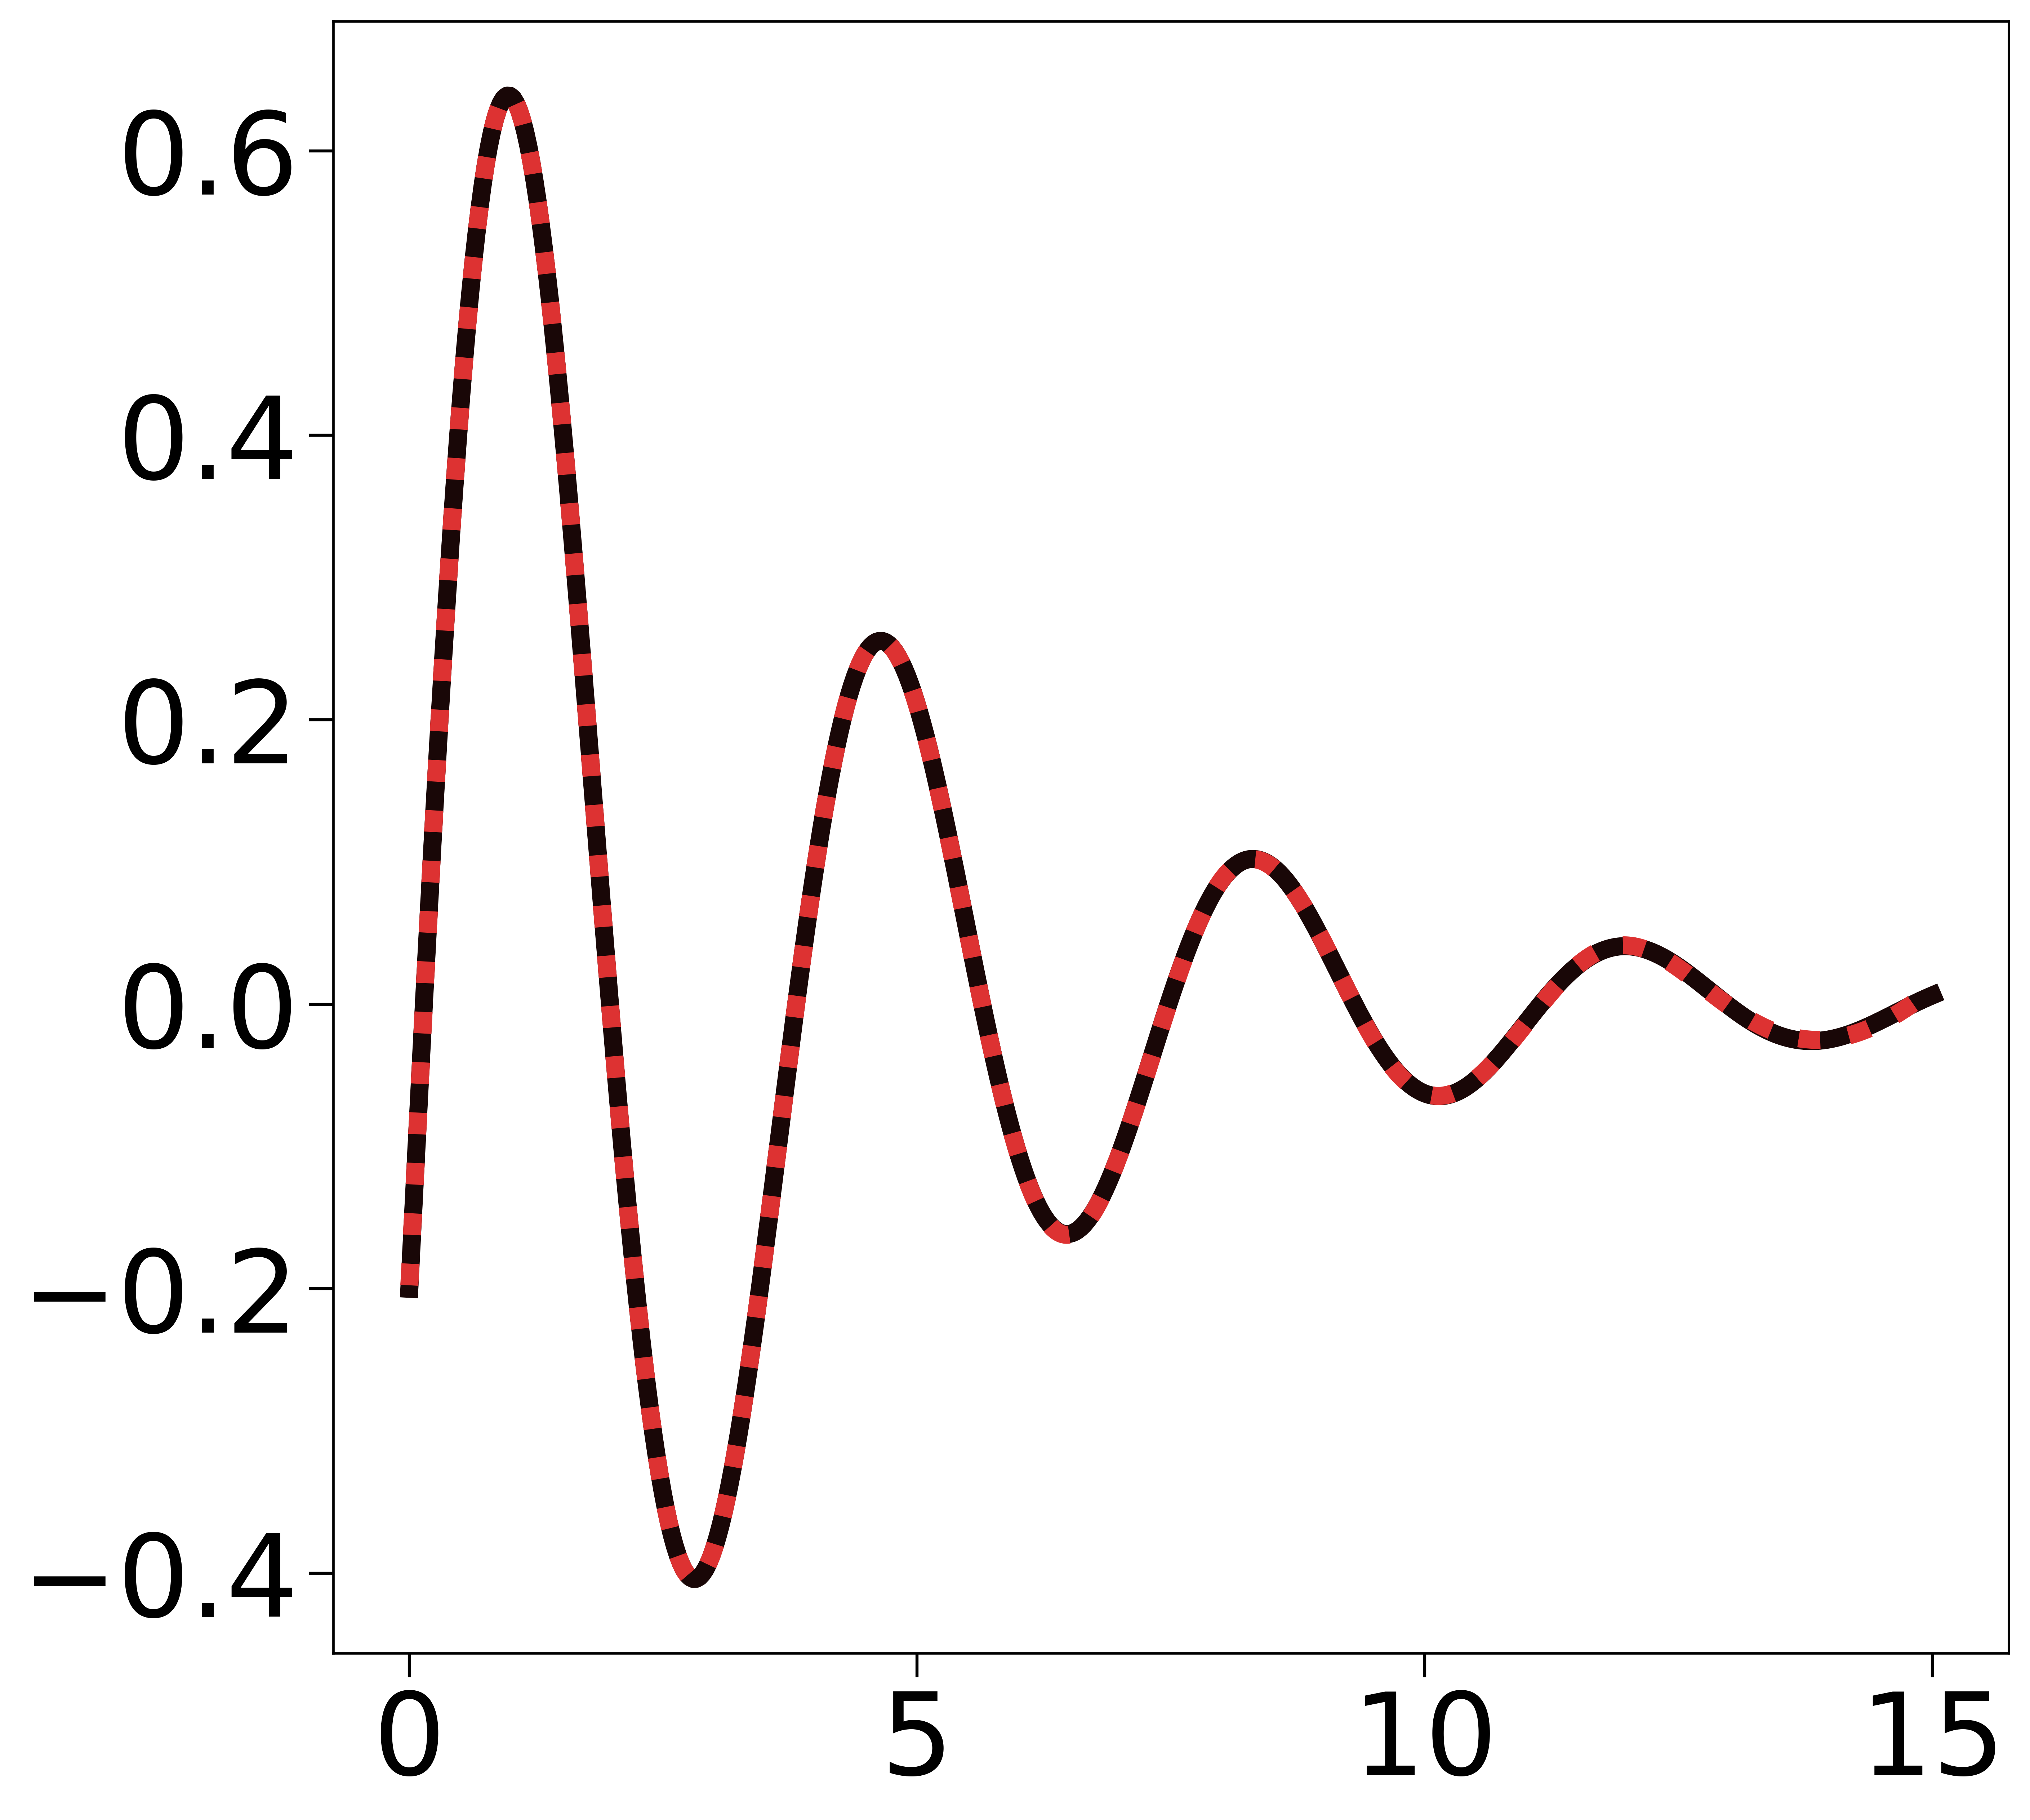

In [11]:
i_scenario = 30

# plt.plot(InputDF['t'], Psi[:,31])
# plt.xscale('log')

plt.plot(InputDF['t'], Y[:,i_scenario],     '-')
plt.plot(tVecPred, YPred[:,i_scenario], ':')